# Predict Future Sales

## Imports

In [1]:
import pandas as pd
pd.set_option('float_format', '{0:.2f}'.format)

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

## Import data

In [38]:
train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")
categories = pd.read_csv("data/item_categories.csv")
shops = pd.read_csv("data/shops.csv")
test = pd.read_csv("data/test.csv")

In [39]:
df_train = train.copy()

## Data Cleaning

### Cleaning the training set

In [40]:
df_train.rename(columns={'item_cnt_day' : 'item_volume'}, inplace=True)

In [41]:
# Replace negative price
df_train["item_price"] = np.where(df_train.item_price < 0,
                            df_train[(df_train.date_block_num==4) & (df_train.shop_id==32) & (df_train.item_id==2973)]["item_price"].median(),
                            df_train.item_price)

#### Remove outliers

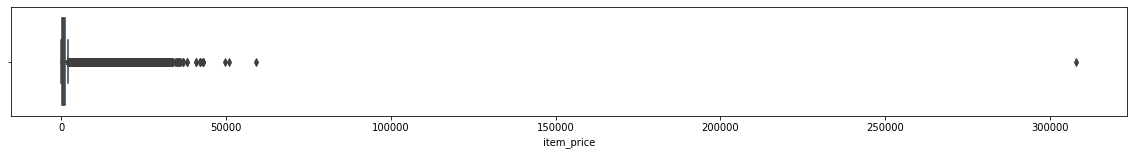

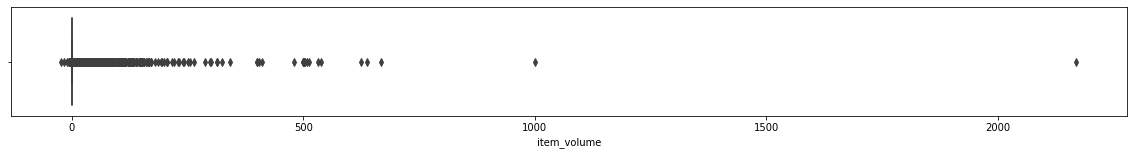

In [42]:
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_price)
plt.show()
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_volume)
plt.show()

In [43]:
# Remove outliers
df_train = df_train[df_train.item_price < 100000]
df_train = df_train[df_train.item_volume < 100]

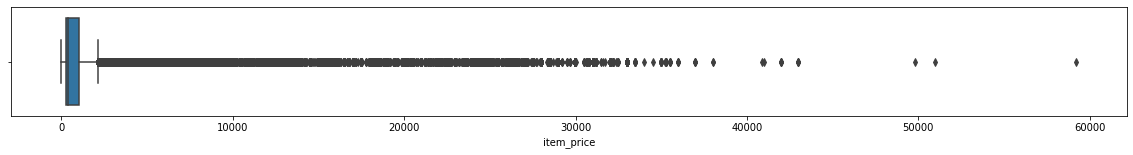

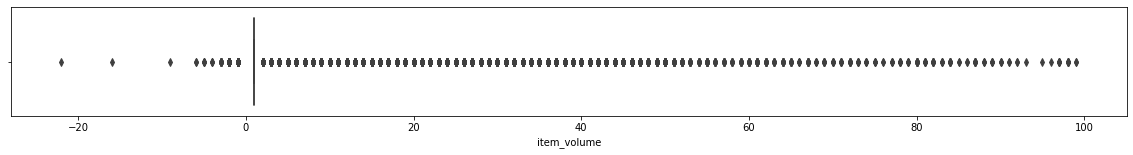

In [44]:
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_price)
plt.show()
plt.figure(figsize=(20,2))
sns.boxplot(df_train.item_volume)
plt.show()

### Group by Month, Shop & Item

In [45]:
df_train["date"] = pd.to_datetime(df_train["date"], format='%d.%m.%Y')
df_train["month"] = df_train["date"].dt.month
df_train["year"] = df_train["date"].dt.year
#df_train["month_year"] = df_train["date"].dt.strftime('%Y-%m')
#df_train["month_year"] = pd.to_datetime(df_train["month_year"])

In [46]:
gp = df_train.groupby(["date_block_num", "year", "month", "shop_id", "item_id"]).agg({'item_volume' : 'sum', 'item_price' : 'mean'}).reset_index()

In [47]:
gp

,date_block_num,year,month,shop_id,item_id,item_volume,item_price
0,0,2013,1,0,32,6.00,221.00
1,0,2013,1,0,33,3.00,347.00
2,0,2013,1,0,35,1.00,247.00
3,0,2013,1,0,43,1.00,221.00
4,0,2013,1,0,51,2.00,128.50
...,...,...,...,...,...,...,...
1609112,33,2015,10,59,22087,6.00,119.00
1609113,33,2015,10,59,22088,2.00,119.00
1609114,33,2015,10,59,22091,1.00,179.00
1609115,33,2015,10,59,22100,1.00,629.00


In [48]:
# VOLUME CAN BE 0 (returns are negative)
df_train[(df_train.item_id==5643) & (df_train.date_block_num==0) & (df_train.shop_id==2)]

,date,date_block_num,shop_id,item_id,item_price,item_volume,month,year
32745,2013-01-02,0,2,5643,2385.21,-1.00,1,2013
32746,2013-01-06,0,2,5643,2390.00,1.00,1,2013


### Prepare test set and concatenate with training set

In [49]:
df_test = test.copy()

In [50]:
df_test["date_block_num"] = 34
df_test["year"] = 2015
df_test["month"] = 11
df_test["item_volume"] = 0
df_test["item_price"] = 0

In [51]:
df_test = df_test[["date_block_num", "year", "month", "shop_id", "item_id", "item_volume", "item_price"]]

In [52]:
df = pd.concat([gp, df_test], ignore_index=True)

In [53]:
df["revenue"] = df["item_volume"] * df["item_price"]

In [54]:
def downcast_dtypes(df):
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols = [c for c in df if df[c].dtype in ["int64", "int32"]]
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols] = df[int_cols].astype(np.int16)
    return df

df = downcast_dtypes(df)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823317 entries, 0 to 1823316
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date_block_num  int16  
 1   year            int16  
 2   month           int16  
 3   shop_id         int16  
 4   item_id         int16  
 5   item_volume     float32
 6   item_price      float32
 7   revenue         float32
dtypes: float32(3), int16(5)
memory usage: 38.3 MB


### Prepare Shops & Categories

In [56]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[["shop_id", "city_code"]]

In [57]:
categories['split'] = categories['item_category_name'].str.split('-')
categories['cat'] = categories['split'].map(lambda x: x[0].strip())
categories['cat_code'] = LabelEncoder().fit_transform(categories['cat'])
# if subcategory is nan then category
categories['subcat'] = categories['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories['subcat_code'] = LabelEncoder().fit_transform(categories['subcat'])
categories = categories[["item_category_id", "cat_code", "subcat_code"]]

In [58]:
items.drop(columns=["item_name"], axis=1, inplace=True)

### Merge & process dates

In [59]:
full_data = pd.merge(df, items, on=["item_id"], how='left')
full_data = pd.merge(full_data, categories, on="item_category_id", how='left')
full_data = pd.merge(full_data, shops, on="shop_id", how='left')
#full_data.drop(columns=["item_category_id"], inplace=True)

In [60]:
df = full_data.copy()

In [61]:
df

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,subcat_code,city_code
0,0,2013,1,0,32,6.00,221.00,1326.00,40,11,4,0
1,0,2013,1,0,33,3.00,347.00,1041.00,37,11,1,0
2,0,2013,1,0,35,1.00,247.00,247.00,40,11,4,0
3,0,2013,1,0,43,1.00,221.00,221.00,40,11,4,0
4,0,2013,1,0,51,2.00,128.50,257.00,57,13,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1823312,34,2015,11,45,18454,0.00,0.00,0.00,55,13,2,21
1823313,34,2015,11,45,16188,0.00,0.00,0.00,64,14,42,21
1823314,34,2015,11,45,15757,0.00,0.00,0.00,55,13,2,21
1823315,34,2015,11,45,19648,0.00,0.00,0.00,40,11,4,21


### KPIs

In [62]:
def _add_kpi(df, index_columns, col_name, kpi, agg, lag=0):
    temp = df.groupby(index_columns).agg({ kpi : agg}).reset_index()
    temp["date_block_num"] = temp["date_block_num"] + lag
    if lag==0:
        lag_str = ""
    else:
        lag_str = "_" + str(lag)
    temp = temp.rename(columns={ kpi : (col_name + lag_str) })
    df = pd.merge(df, temp, how='left', on = index_columns)
    # Avoid 0 volume
    df[col_name + lag_str] = np.where(df[col_name + lag_str]==0, 1, df[col_name + lag_str])
    if lag!=0:
        df[col_name + lag_str + "_trend"] = \
        (df["item_volume"] - df[col_name + lag_str]) / df[col_name + lag_str]
    return df

In [63]:
def _add_lag_item(df, lag=0):
    temp = df[["date_block_num", "item_id", "shop_id", "item_volume"]]
    temp["date_block_num"] = temp["date_block_num"] + lag   
    temp = temp.rename(columns={ "item_volume" : ("item_volume_" + str(lag)) })
    df = pd.merge(df, temp, how='left', on = ["date_block_num", "shop_id", "item_id"])
    # Avoid 0 volume
    df["item_volume_" + str(lag)] = np.where(df["item_volume_" + str(lag)]==0, 1, df["item_volume_" + str(lag)])
    df["item_volume_" + str(lag) + "_trend"] = \
    (df["item_volume"] - df["item_volume_" + str(lag)]) / df["item_volume_" + str(lag)]
    return df 

#### Sum

In [64]:
# Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum")
# Sum of item_volume groupby month, shop
df = _add_kpi(df, ["date_block_num", "shop_id"], "sum_volume_month_shop", "item_volume", "sum")
# Sum of item_volume groupby month, shop, category
df = _add_kpi(df, ["date_block_num", "shop_id", "item_category_id"], "sum_volume_month_shop_category", "item_volume", "sum")

#### Mean

In [65]:
# Mean of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "mean_volume_month", "item_volume", "mean")
# Mean of item_volume groupby month, shop
df = _add_kpi(df, ["date_block_num", "shop_id"], "mean_volume_month_shop", "item_volume", "mean")
# Mean of item_volume groupby month, shop, category
df = _add_kpi(df, ["date_block_num", "shop_id", "item_category_id"], "mean_volume_month_shop_category", "item_volume", "mean")

In [66]:
df

,date_block_num,year,month,shop_id,item_id,item_volume,item_price,revenue,item_category_id,cat_code,subcat_code,city_code,sum_volume_month,sum_volume_month_shop,sum_volume_month_shop_category,mean_volume_month,mean_volume_month_shop,mean_volume_month_shop_category
0,0,2013,1,0,32,6.00,221.00,1326.00,40,11,4,0,131479.00,5578.00,1838.00,2.08,2.34,2.21
1,0,2013,1,0,33,3.00,347.00,1041.00,37,11,1,0,131479.00,5578.00,302.00,2.08,2.34,1.44
2,0,2013,1,0,35,1.00,247.00,247.00,40,11,4,0,131479.00,5578.00,1838.00,2.08,2.34,2.21
3,0,2013,1,0,43,1.00,221.00,221.00,40,11,4,0,131479.00,5578.00,1838.00,2.08,2.34,2.21
4,0,2013,1,0,51,2.00,128.50,257.00,57,13,8,0,131479.00,5578.00,60.00,2.08,2.34,1.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823312,34,2015,11,45,18454,0.00,0.00,0.00,55,13,2,21,1.00,1.00,1.00,1.00,1.00,1.00
1823313,34,2015,11,45,16188,0.00,0.00,0.00,64,14,42,21,1.00,1.00,1.00,1.00,1.00,1.00
1823314,34,2015,11,45,15757,0.00,0.00,0.00,55,13,2,21,1.00,1.00,1.00,1.00,1.00,1.00
1823315,34,2015,11,45,19648,0.00,0.00,0.00,40,11,4,21,1.00,1.00,1.00,1.00,1.00,1.00


#### Lags

In [67]:
# Lag 1 month Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 1)
# Lag 12 months Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 12)
# Lag 6 months Sum of item_volume groupby month
df = _add_kpi(df, ["date_block_num"], "sum_volume_month", "item_volume", "sum", 6)

In [68]:
# Lag 1 month Sum of item_volume
df = _add_lag_item(df, 1)
# Lag 12 month Sum of item_volume
df = _add_lag_item(df, 12)
# Lag 6 month Sum of item_volume
df = _add_lag_item(df, 6)

/Users/taharaouz/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
df_test = df[df.date_block_num==34]

In [70]:
df_test.columns

Index(['date_block_num', 'year', 'month', 'shop_id', 'item_id', 'item_volume',
       'item_price', 'revenue', 'item_category_id', 'cat_code', 'subcat_code',
       'city_code', 'sum_volume_month', 'sum_volume_month_shop',
       'sum_volume_month_shop_category', 'mean_volume_month',
       'mean_volume_month_shop', 'mean_volume_month_shop_category',
       'sum_volume_month_1', 'sum_volume_month_1_trend', 'sum_volume_month_12',
       'sum_volume_month_12_trend', 'sum_volume_month_6',
       'sum_volume_month_6_trend', 'item_volume_1', 'item_volume_1_trend',
       'item_volume_12', 'item_volume_12_trend', 'item_volume_6',
       'item_volume_6_trend'],
      dtype='object')

In [72]:
shops_keep = df_test.shop_id.unique()
items_keep = df_test.item_id.unique()

In [73]:
df = df[df.shop_id.isin(shops_keep)]

In [74]:
df = df[df.item_id.isin(items_keep)]

# Model

In [75]:
df = df.fillna(0)

In [76]:
X_train = df[df.date_block_num.isin(range(1,34))].drop(columns=["item_volume"])
y_train = df[df.date_block_num.isin(range(1,34))]["item_volume"]

#X_val = df[df.date_block_num==33].drop(columns=["item_volume"])
#y_val = df[df.date_block_num==33][["item_volume"]]

X_test = df[df.date_block_num==34].drop(columns=["item_volume"])

In [77]:
#columns_to_keep = ['date_block_num', 'month', 'shop_id', 'item_id', 'item_price', 'revenue',
#       'sum_volume_month', 'sum_volume_month_shop',
#       'sum_volume_month_shop_category', 'mean_volume_month',
#       'mean_volume_month_shop', 'mean_volume_month_shop_category',
#       'sum_volume_month_1', 'sum_volume_month_1_trend', 'sum_volume_month_12',
#       'sum_volume_month_12_trend', 'item_volume_1', 'item_volume_1_trend']
#X_train = X_train[columns_to_keep]
#X_test = X_test[columns_to_keep]

In [78]:
#scaler = StandardScaler()
#X_train_np = scaler.fit_transform(X_train)
#X_test_np = scaler.fit_transform(X_test)

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [80]:
#X_train = pd.DataFrame(X_train_np, columns=X_train.columns, index=X_train.index)
#X_test = pd.DataFrame(X_test_np, columns=X_test.columns, index=X_test.index)

### Random Forest

In [60]:
model = RandomForestRegressor(n_estimators=5, max_depth=10)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=10, n_estimators=5)

In [42]:
param_grid = [
    {'n_estimators': [5, 10], 'max_depth': [5, 10]},
  ]

grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(max_depth=5, n_estimators=3),
             param_grid=[{'max_depth': [5, 10], 'n_estimators': [5, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [43]:
model = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 5}

In [44]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, n_estimators=5)

In [61]:
scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
np.sqrt(-scores)

array([100.09735302,   1.20489308,   0.67444852,   1.38624858,
         2.06951541])

In [53]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

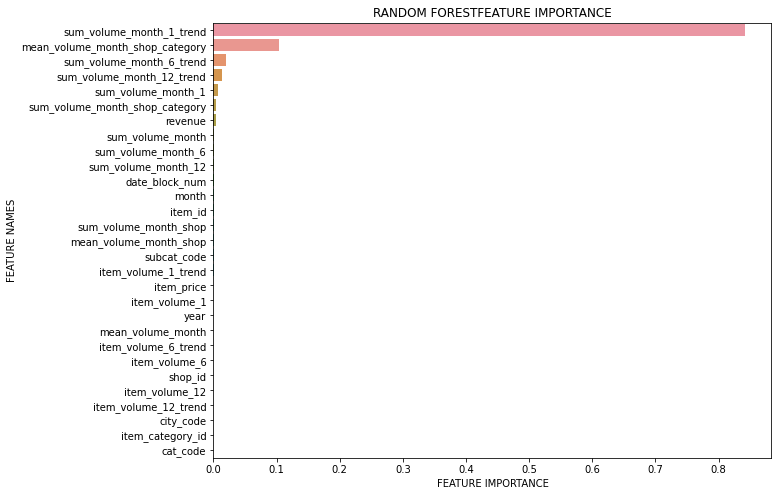

In [55]:
plot_feature_importance(model.feature_importances_, df.drop(columns=["item_volume"]).columns,'RANDOM FOREST')

### xgboost

In [84]:
model = xgb.XGBRegressor(max_depth=6, n_estimators=40)

In [85]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=40, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=3)
np.sqrt(-scores)

array([167.60278446,   1.05278216,   1.68240137])

In [110]:
param_grid = [
    {'n_estimators': [25, 30, 35], 'max_depth': [6]},
  ]

grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0, gpu_id=-1,
                                    importance_type='gain',
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_delta_step=0,
                                    max_depth=6, min_child_weight=1,
                                    missing=nan, monotone_constraints='()',
                                    n_estimators=30, n_jobs=0,
                                    num_parallel_tree=1, random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, subsample=1,
                                    tree_method='exact', validate_parameters=1,
                                    verbosity=None),
       

In [111]:
model = grid_search.best_estimator_
grid_search.best_params_

{'max_depth': 6, 'n_estimators': 35}

In [113]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=35, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

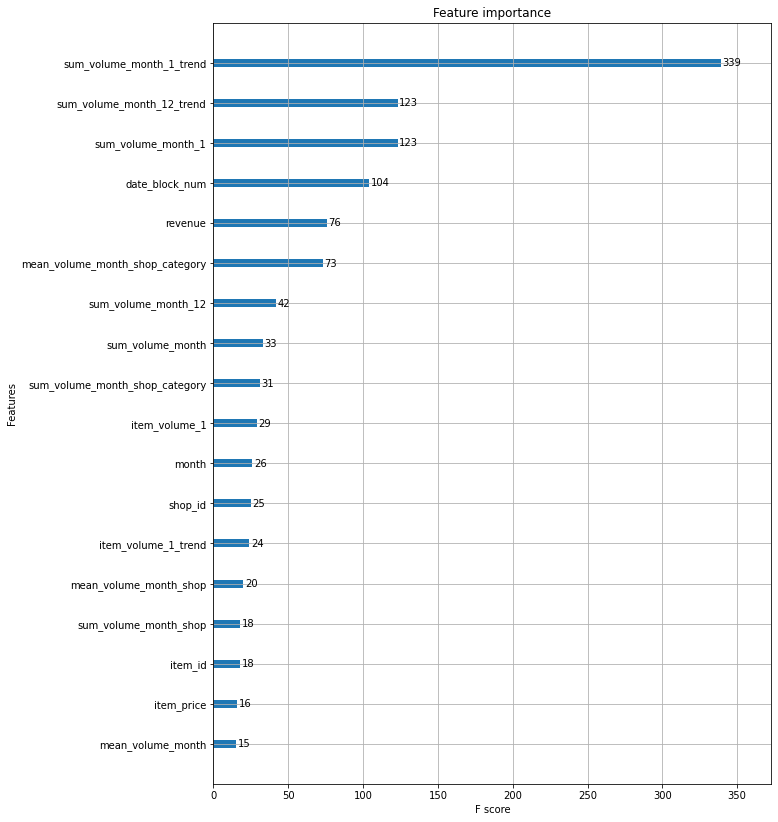

In [114]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

# Submission

In [43]:
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=35, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [44]:
y_test = model.predict(X_test).clip(0,20 )

In [45]:
submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('submission.csv', index=False)